# Questions
1. 지역에 따라서 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까 
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

- <span style="font-size:22px; font-style:italic; font-weight:bold">Goal: 어떤 게임을 설계해야 할까</span>

# Import and Load

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_all = pd.read_csv('vgames2_clean.csv')

# EDA

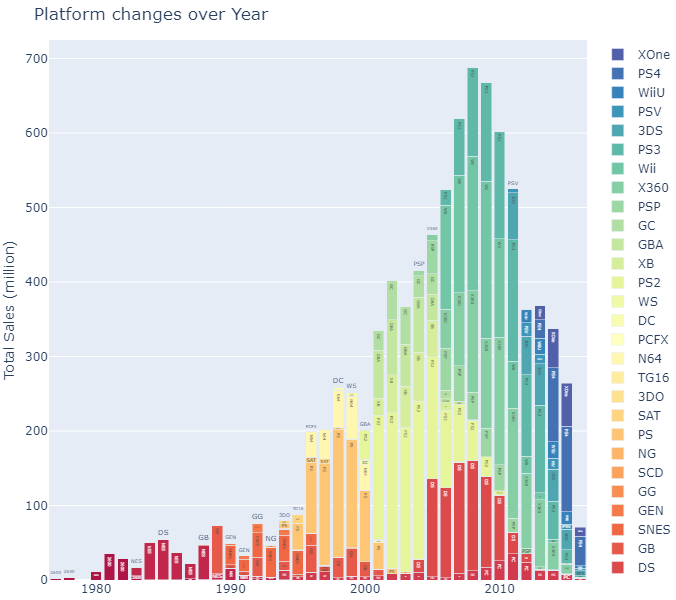

In [3]:
temp = data_all.pivot_table(values='Total_Sales', index='Year', columns='Platform',
                            aggfunc='sum').fillna(0).reset_index()
temp_ = data_all.groupby(['Year', 'Platform'])['Total_Sales'].sum().reset_index()
t = temp_.groupby('Year')['Total_Sales'].nlargest(10).reset_index().level_1.values
order = temp_.iloc[t]['Platform'].unique()
colors = sns.color_palette("Spectral", len(temp.columns)-1)

fig = []
for i, col in enumerate(order):
    fig.append(go.Bar(name=col, x=temp['Year'], y=temp[col],
                      text=col, marker_color='rgb'+str(colors[i])))
figs = go.Figure(fig)
figs.update_layout(barmode='stack', height=600,
                   margin=dict(l=10, r=0, t=40, b=20),
                   title="Platform changes over Year",
                   yaxis_title="Total Sales (million)")
figs.show()

<img src="https://blog.kakaocdn.net/dn/bVESI6/btrKD3DW1lX/6kn56BNB0CL0RmS4CIrwkK/img.png">

최근의 경향을 보기위해 마지막인 2016년에 사용하는 플랫폼을 기준으로 기간을 제한한다. <br>
가장 출시년도가 이른 플랫폼은 X360으로 2005년이다. 따라서 2005년 이후의 데이터만 사용한다.

In [4]:
data = data_all.query("Year>=2005")

In [5]:
temp = data.pivot_table(values='Total_Sales', index='Year', columns='Platform',
                        aggfunc='sum').fillna(0).reset_index()
temp_ = data.groupby(['Year', 'Platform'])['Total_Sales'].sum().reset_index()
t = temp_.groupby('Year')['Total_Sales'].nlargest(10).reset_index().level_1.values
order = temp_.iloc[t]['Platform'].unique()
colors = sns.color_palette("Spectral", len(temp.columns)-1)

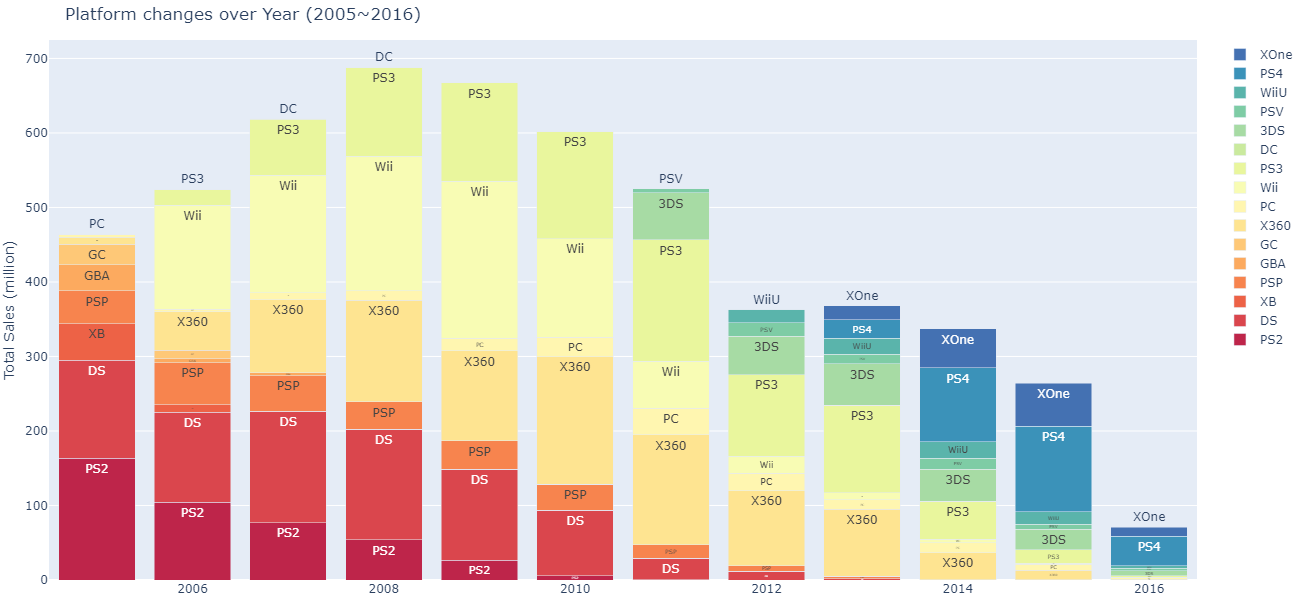

In [6]:
fig = []
for i, col in enumerate(order):
    fig.append(go.Bar(name=col, x=temp['Year'], y=temp[col],
                      text=col, marker_color='rgb'+str(colors[i])))
figs = go.Figure(fig)
figs.update_layout(barmode='stack', height=600,
                   margin=dict(l=10, r=0, t=40, b=20),
                   title="Platform changes over Year (2005~2016)",
                   yaxis_title="Total Sales (million)")
figs.show()

<img src="https://blog.kakaocdn.net/dn/bsSy05/btrKzf0DIa5/0qkEzfUzDtZw5NqRcNOkf0/img.png">

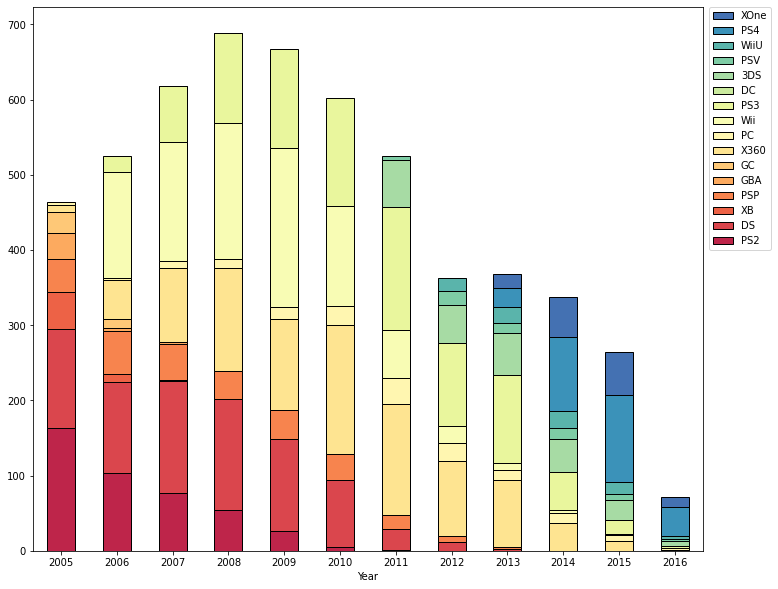

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
temp = temp.reindex(columns=['Year'] + list(order))
temp.plot(x='Year', kind='bar', stacked=True, color=colors,
          ax=ax, linewidth=1, edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.11, 1.01))
plt.xticks(rotation=0)
plt.show()

In [8]:
sales = [col for col in data.columns if col.endswith('Sales') and not col.startswith('Total')]

## 지역별 선호 장르
- 어떤 지역에 가중치를 두어야하는가?

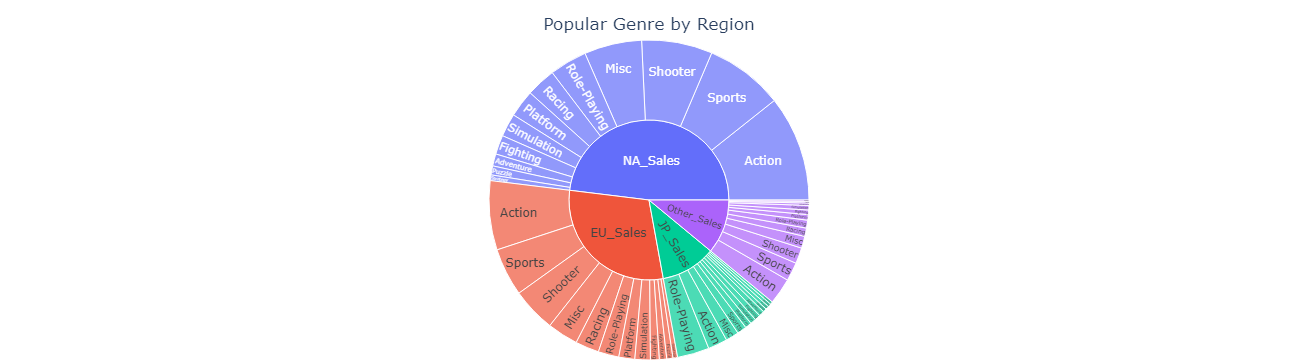

In [9]:
temp = pd.melt(data, id_vars='Genre', value_vars=sales, var_name='Region', value_name='Sales')

fig = px.sunburst(temp, path=['Region', 'Genre'], values='Sales')
fig.update_layout(margin={'t':40, 'b':0, 'l':0, 'r':0},
                  title={'text': "Popular Genre by Region",
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

<img src="https://blog.kakaocdn.net/dn/kLSWF/btrKQjs9MsM/nvaWdmCKJyrrPk5MrbmDt1/img.png">

In [10]:
genre_sales = data.groupby('Genre')[sales].sum()

In [11]:
cmap = plt.get_cmap('Greys')
colors = list(cmap(np.linspace(0.45, 0.85, len(genre_sales))))
colors[0:3] = ['dodgerblue', 'skyblue', 'powderblue']
explode = [0.1] + [0] * 7

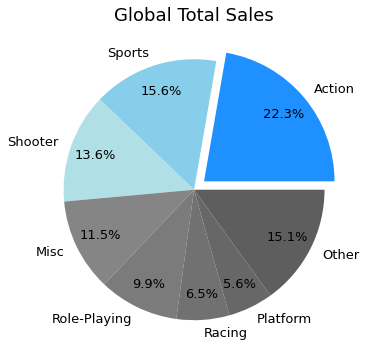

In [12]:
genre_global_sales = (data.groupby('Genre')['Total_Sales'].sum()
                      .sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
ax.pie(np.append(genre_global_sales.values[:7], 
                 sum(genre_global_sales.values)-sum(genre_global_sales.values[:7])), 
       labels=np.append(genre_global_sales.index[:7], 'Other'),
       autopct='%.1f%%', colors=colors, explode=explode,
       pctdistance=0.8,
       textprops={'fontsize': 13}
      )
plt.title("Global Total Sales", fontsize=18)
plt.show()

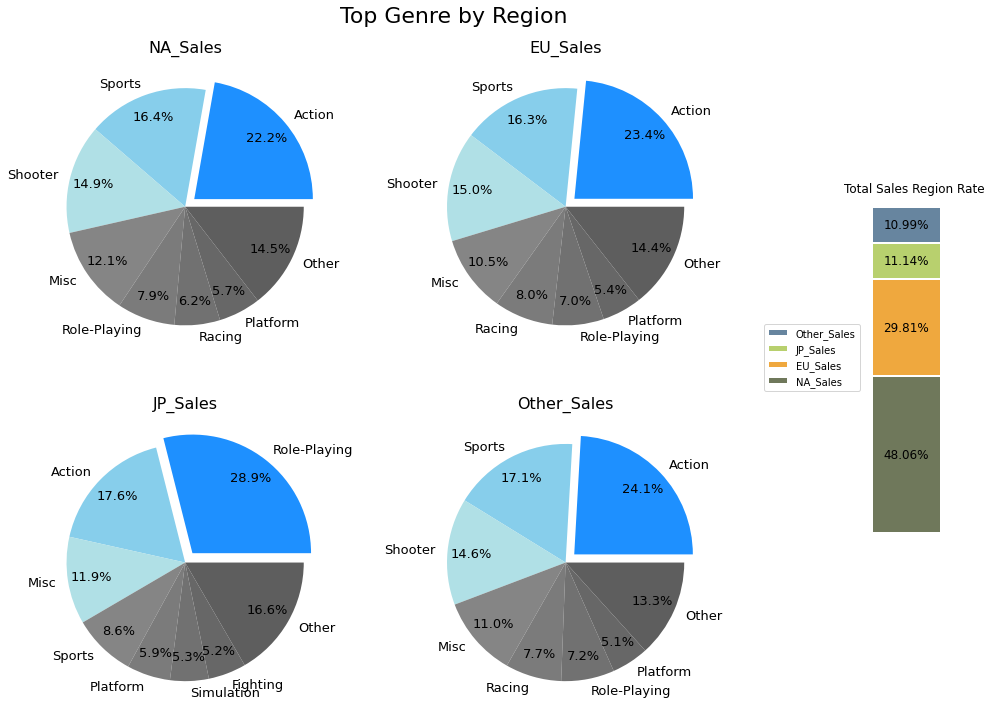

In [13]:
fig = plt.figure(figsize=(15, 12))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[15, 3])

axs0 = subfigs[0].subplots(2, 2)
for i, col in enumerate(sales):
    temp = genre_sales[col].sort_values(ascending=False)
    axs0[i//2, i%2].pie(np.append(temp.values[:7], sum(temp.values)-sum(temp.values[:7])), 
           labels=np.append(temp.index[:7], 'Other'),
           autopct='%.1f%%', colors=colors, explode=explode,
           pctdistance=0.8,
           textprops={'fontsize': 13}
          )

    axs0[i//2, i%2].set_title(col, fontsize=16)
    

axs1 = subfigs[1].subplots()
genre_sales.sum().to_frame().T.plot(kind='bar', stacked=True, ax=axs1,
                                    color=['#6f785b', '#efa83e', '#b8d06e', '#67859f'],
                                    linewidth=2, edgecolor='w')
for bar in axs1.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = str(round(height / genre_sales.sum().sum() * 100, 2)) + '%'
    label_x = x + width / 2
    label_y = y + height / 2
    axs1.text(label_x, label_y, label_text, ha='center',    
            va='center', fontsize=12)
axs1.text(x-0.2, genre_sales.sum().sum()+300, 'Total Sales Region Rate', va='center',
          fontdict={'size':12})
handles, labels = axs1.get_legend_handles_labels()
axs1.legend(handles[::-1], labels[::-1], bbox_to_anchor=(0.2, 0.6))
axs1.set_xticks([])
axs1.set_xlabel('Total Sales')
axs1.set_ylim(-3000, 8000)
axs1.axis('off')

plt.suptitle("Top Genre by Region", y=0.94, fontsize=22)
plt.show()

전체 기간동안 판매된 게임 장르의 국가별 분포를 보면 일본을 제외한 모든 지역에서 액션 장르가 가장 많이 팔렸다.<br>
다음으로 스포츠, 슈팅 순서로 높은 판매 비율을 차지했다.<br>
일본을 제외한 약 90%의 지역에서 이러한 분포를 가져 전체 지역의 장르별 판매량도 유사한 비율을 가진다. <br>

일본은 롤플레잉 장르가 가장 많이 팔렸고, 다음이 액션, 미분류 순서이다. <br>

전체 시장 크기의 변화를 보고 일본의 시장이 큰 부분을 차지하지 않는다면 전체 트랜드를 그대로 사용해도 될 것이다.

### 시장 크기 변화
가장 큰 파이를 차지하는 곳이 어딘가?

In [14]:
year_region = data.groupby('Year')[sales].sum()

In [15]:
year_region_rate = year_region.apply(lambda x: x/year_region.sum(axis=1))

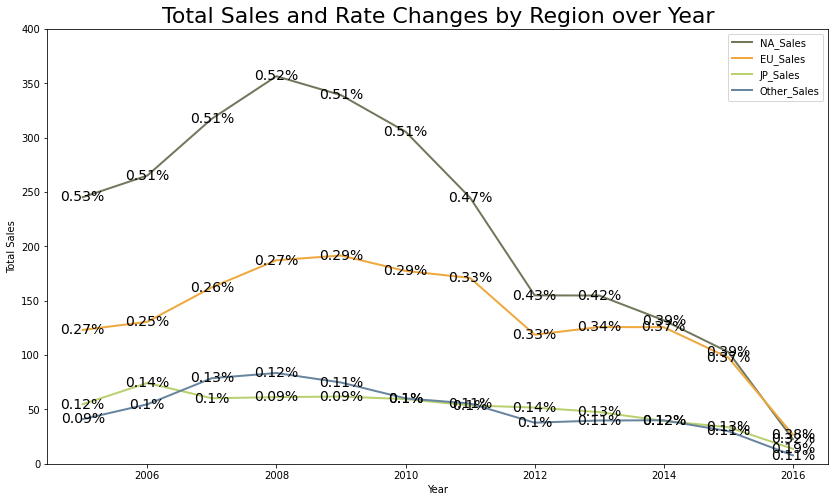

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))
year_region.plot(linewidth=2, 
                 color=['#6f785b', '#efa83e', '#b8d06e', '#67859f'], 
                 ax=ax)
for i in range(len(year_region)):
    for j in range(len(year_region.columns)):
        y = 0
        if j%2==0:
            y = 0
        else:
            y = 0
        ax.text(year_region.index[i], year_region.iloc[i, j]+y,
                str(round(year_region_rate.iloc[i, j], 2)) + '%',
                va='center', ha='center', fontsize=14)
plt.ylim(0, 400)
plt.title("Total Sales and Rate Changes by Region over Year", fontsize=22)
plt.ylabel("Total Sales")
plt.show()

2010년 까지는 북미지역이 판매량의 50%을 차지했지만 점차 줄어들어 2014년부터는 유럽과 거의 비슷하다.
2016년에는 유럽 지역의 판매량이 북미 지역의 판매량을 넘어섰지만, 2016년의 모든 출시 게임이 있는게 아니라 정확한 비율은 더 기다려봐야 한다.

일본과 이외 지역에서는 전체의 10% 정도씩 꾸준히 차지한다.

- 현재는 북미와 유럽에서 약 60%의 비율을 차지한다.
- 일본의 인구수 보다 북미는 약 5배, 유럽은 6배 정도 많다.
- 인구수 차이로 판매 비율의 차이를 보일 수는 있으나 북미 시장만큼 유럽 시장의 선호도에 우선순위를 두어야한다.
- 위에 지역별 장르 선호도를 봤을 때 일본만 다른 분포를 보여준다
- 일본 시장에 접근하기 위해서는 다른 전략이 필요하다.

-> 그렇다면 시간이 흐르면서 지역별 선호하는 장르에 변화가 있는가?

## 연도별 게임 트랜드

### 전체 기간동안 선호하는 장르

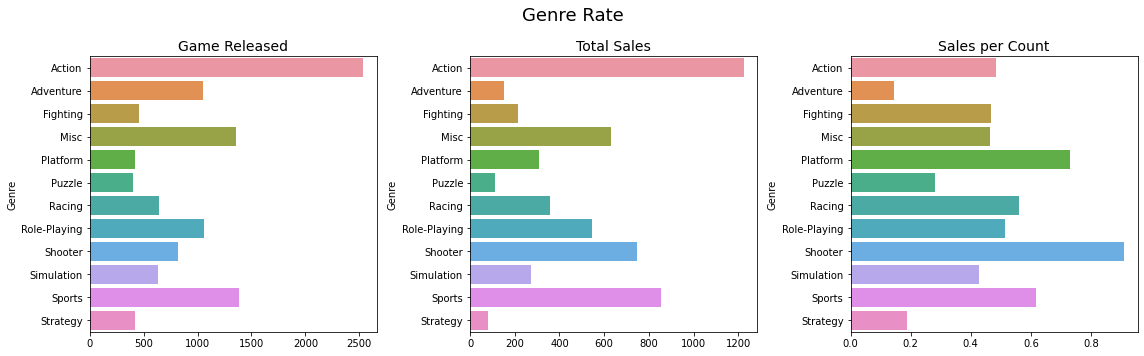

In [17]:
genre_rate = (data.groupby('Genre')['Total_Sales']
              .agg(['count', 'sum']).reset_index())
genre_rate['sales_per_count'] = genre_rate['sum'] / genre_rate['count']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, col in enumerate(['count', 'sum', 'sales_per_count']):
    sns.barplot(x=genre_rate[col], y=genre_rate['Genre'], ax=axes[i])
    axes[i].set_xlabel('')
axes[0].set_title("Game Released", fontsize=14)
axes[1].set_title("Total Sales", fontsize=14)
axes[2].set_title("Sales per Count", fontsize=14)

plt.suptitle("Genre Rate", fontsize=18)
plt.tight_layout()
plt.show()

전체 기간으로 장르별로 얼마나 많은 게임이 출시 되었는지, 팔렸는지를 보면, 액션 장르가 가장 많이 출시되어 판매량이 가장 높게 나타났다. 그 다음으로 스포츠 게임도 마찬가지로 많이 출시되고 많이 판매되었다.<br>

하지만 슈팅 장르가 출시된 수에 비해 많은 수익을 내고 있는 것을 볼 수 있다.
출시 수 대비 판매량이 많은 장르로는 플랫포머, 스포츠가 있다.
전체 기간동안의 선호도가 지금까지도 이어지는지 확인해야한다.

### 연도별 선호 장르

In [18]:
year_genre = data.pivot_table(values='Total_Sales',
                              index='Year',
                              columns='Genre',
                              aggfunc=['sum', 'count']).fillna(0)

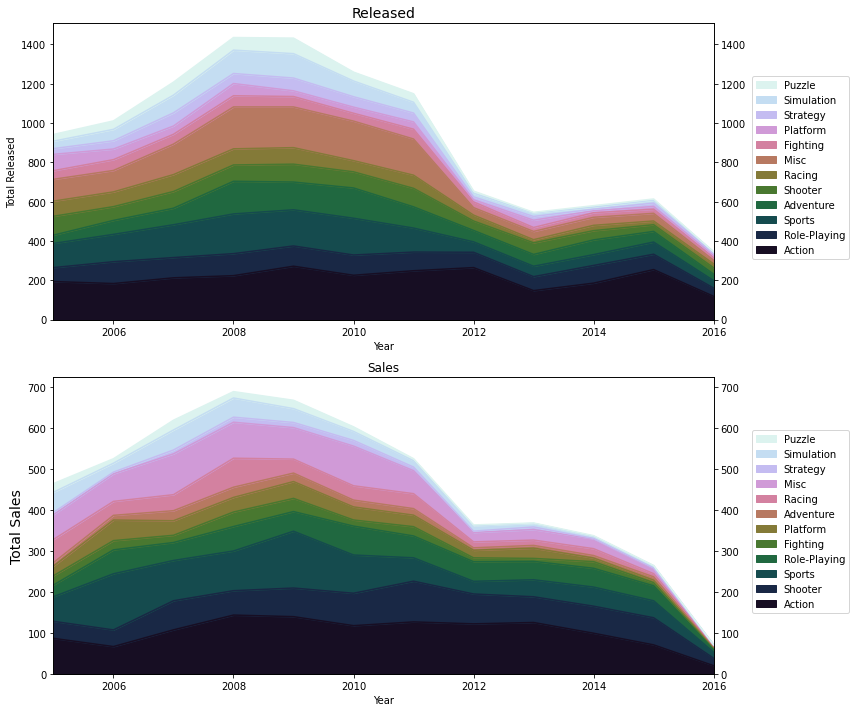

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for i, col in enumerate(['count', 'sum']):
    year_genre[col].T.sort_values(2016, ascending=False).T.plot.area(
        ax=axes[i], color=sns.color_palette("cubehelix", n_colors=len(year_genre[col].columns)))
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 0.84))
    axes[i].set_xlim(2005, 2016)
    
axes[0].set_title("Released", fontsize=14)
axes[0].set_ylabel("Total Released")
axes[1].set_title("Sales")
axes[1].set_ylabel("Total Sales", fontsize=14)

axes01 = axes[0].twinx()
axes01.set_ylim(axes[0].get_ylim())
axes11 = axes[1].twinx()
axes11.set_ylim(axes[1].get_ylim())

plt.tight_layout()
plt.show()

In [20]:
year_genre_normal = {}
year_genre_normal['sum'] = year_genre['sum'].apply(lambda x: x/year_genre['sum'].sum(axis=1))
year_genre_normal['count'] = year_genre['count'].apply(lambda x: x/year_genre['count'].sum(axis=1))

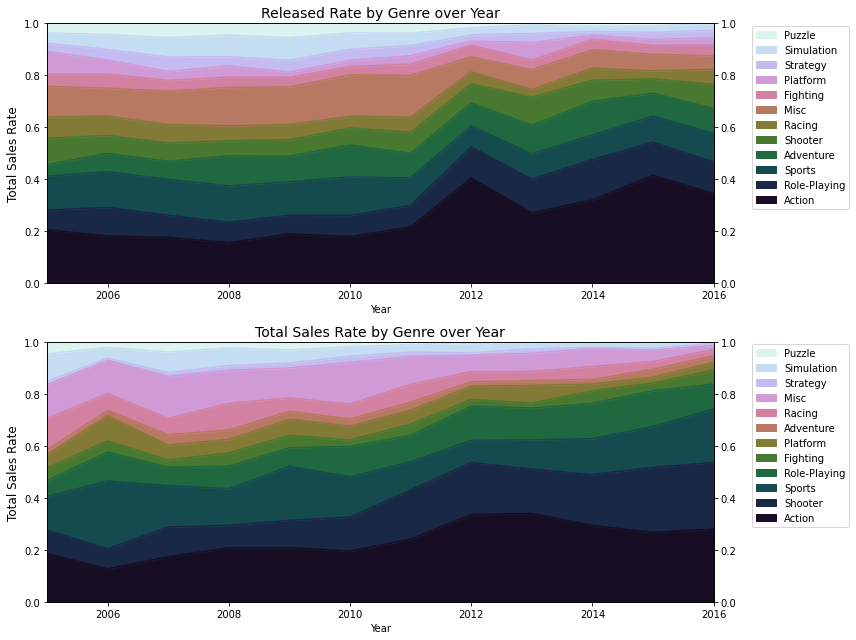

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

for i, col in enumerate(['count', 'sum']):
    year_genre_normal[col].T.sort_values(2016, ascending=False).T.plot.area(#.T.sort_values(2016, ascending=False).T
        ax=axes[i], color=sns.color_palette("cubehelix", n_colors=len(year_genre_normal[col].columns)))
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.01))
    axes[i].set_xlim(2005, 2016)
    axes[i].set_ylim(0, 1)
    
axes01 = axes[0].twinx()
axes01.set_ylim(axes[0].get_ylim())
axes11 = axes[1].twinx()
axes11.set_ylim(axes[1].get_ylim())

axes[0].set_title("Released Rate by Genre over Year", fontsize=14)
axes[0].set_ylabel("Total Sales Rate", fontsize=12)
axes[1].set_title("Total Sales Rate by Genre over Year", fontsize=14)
axes[1].set_ylabel("Total Sales Rate", fontsize=12)

plt.tight_layout()
plt.show()

2005년부터 출시된 장르별 게임의 수와 판매량의 비율을 보여준다. <br>
2016년에 가장 큰 값을 가지는 장르 순으로 정렬했다.
출시되는 비율은 액션이 항상 크고 그다음이 롤플레잉과 스포츠가 거의 유사하고, 그 다음으로 어드벤쳐, 슈팅 순이다.
하지만 판매량을 보면 액션은 많이 출시되어 판매량이 많음을 유추할 수 있지만 두 번째로 많이 팔린 장르가 슈팅이다.
이는 특정한 슈팅 게임이 인기를 끌어서 판매량을 많이 차지하는 것으로 예상된다.
롤플레잉도 판매량 비율이 주춤했다가 2012년 이후부터 다시 증가한다.

### 연도별 가장 많이 출시, 판매된 장르

In [22]:
year_genre_sum_long = (year_genre['sum'].reset_index()
                       .melt(id_vars='Year', value_vars=year_genre['sum'].columns))
year_top_genre_sum = (year_genre_sum_long
                      .iloc[year_genre_sum_long.groupby('Year')['value']
                            .nlargest(3).reset_index().level_1.values])

In [23]:
year_genre_count_long = (year_genre['count'].reset_index()
                         .melt(id_vars='Year', value_vars=year_genre['count'].columns))
year_top_genre_count = (year_genre_count_long
                        .iloc[year_genre_count_long.groupby('Year')['value']
                              .nlargest(3).reset_index().level_1.values])

In [24]:
year_top_genre_sum['Year'] = year_top_genre_sum['Year'].astype(str)
year_top_genre_count['Year'] = year_top_genre_count['Year'].astype(str)

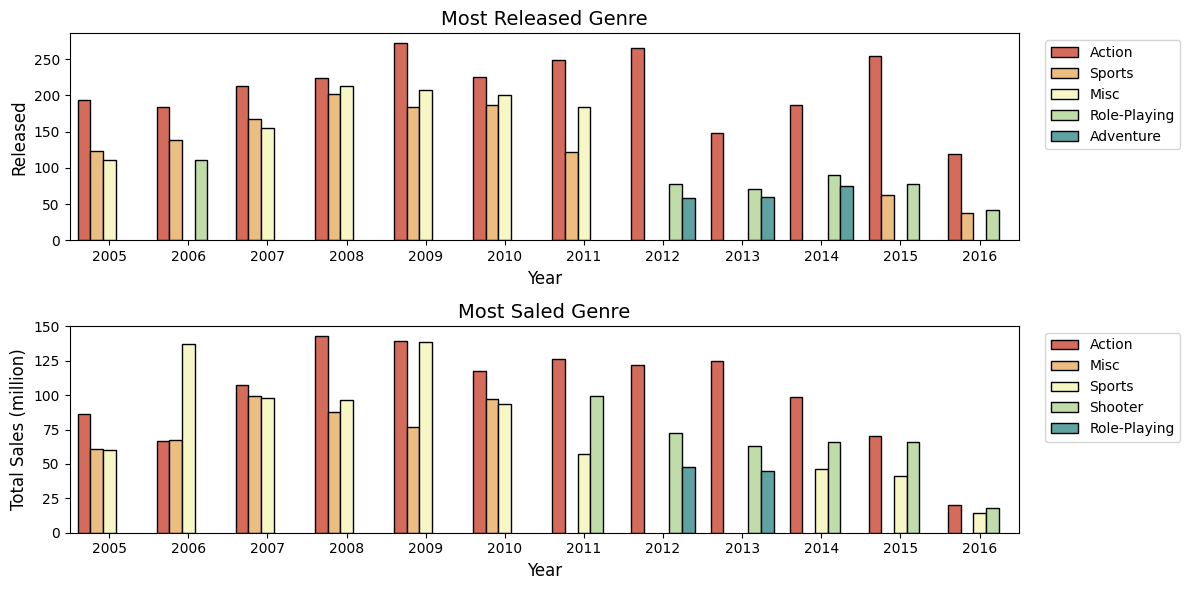

In [25]:
colors = ['#FC5454']*len(year_top_genre_sum)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=100)
for i, df in enumerate([year_top_genre_count, year_top_genre_sum]):
    sns.barplot(data=df, x='Year', y='value', hue='Genre',
                edgecolor='k', palette='Spectral', ax=axes[i])
    axes[i].set_xlabel('Year', fontsize=12)
    axes[i].set_xlim(-0.5, 11.5)
    axes[i].legend(bbox_to_anchor=(1.02, 1))

# for i in range(11):
#     axes[0].vlines(i+0.5, 0, 300, linestyle='-.', color='k', alpha=0.8)
#     axes[1].vlines(i+0.5, 0, 150, linestyle='-.', color='k', alpha=0.8)
    
axes[0].set_ylabel('Released', fontsize=12)
axes[0].set_title("Most Released Genre", fontsize=14)
axes[1].set_ylabel('Total Sales (million)', fontsize=12)
axes[1].set_title("Most Saled Genre", fontsize=14)
plt.tight_layout()
plt.show()

전체 기간 동안 많이 출시되고 많이 판매된 장르 3개를 뽑았다.

모든 연도에서 액션 게임이 가장 많이 출시되었고 가장 많이 팔렸다.
2011년 이전까지는 액션과 스포츠, 미분류된 장르가 주로 출시되었다면 2012년부터는 롤플레잉과 어드벤쳐가 많이 출시되었다.
하지만 액션을 제외한 장르 출시의 하락으로 롤플레잉과 어드벤처가 순위권에 오른 것일 수도 있다.

판매량은 2010년까지 출시량과 유사하게 나타났다.
2006년에는 스포츠게임이 가장 많이 팔렸다. 이때 모든 기간동안 가장 많이 팔린 Wii Sports가 출시되었다. 
2009년에도 스포츠가 많이 팔렸다. Wii Sports Resort다.
2011년 이후부터는 슈팅게임이 많이 팔렸는데 출시된 장르에는 표시되지 않는다. 
이는 슈팅 게임이 다른 장르보다 성공적인 결과를 얻었다고 볼 수 있다.

위로부터 액션과 슈팅, 롤플레잉이 최근 선호하는 장르로 보여진다.

## 출고량이 높은 게임
- 높은 판매량을 올린 게임이 선호하는 장르에 포함되는가?

In [26]:
temp = (data.sort_values('Year')
        .groupby(['Name', 'Genre'])[['Year', 'Total_Sales']]
        .agg({'Year': lambda x: x.values[0],
            'Total_Sales': 'sum'})).reset_index()
top_years = temp.groupby('Year')['Total_Sales'].nlargest(5).reset_index().level_1.values

top_5_of_year = temp.iloc[top_years]

top_5_sum = top_5_of_year.groupby('Year')['Total_Sales'].sum()
top_5_of_year['div'] = top_5_of_year['Year'].map(top_5_sum)
top_5_of_year['Sales_Rate'] = top_5_of_year['Total_Sales'] / top_5_of_year['div'] * 100
top_5_of_year['All'] = 'SALES'
top_5_of_year = top_5_of_year.sort_values(['Year'])
top_5_of_year['Year'] = top_5_of_year['Year'].astype(str)

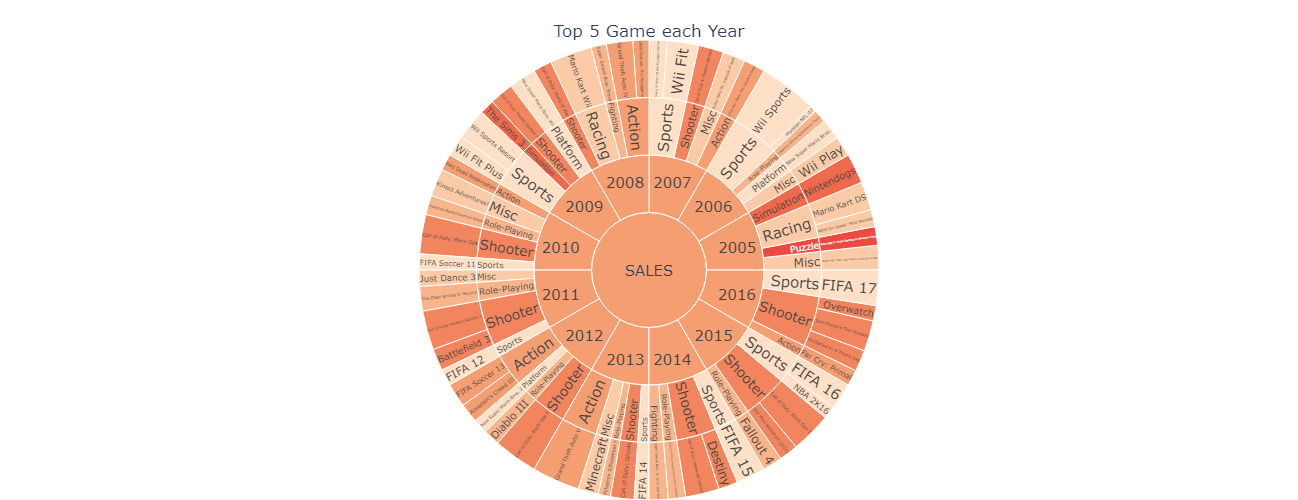

In [27]:
fig = px.sunburst(top_5_of_year, 
                  path=['All', 'Year', 'Genre', 'Name'], values='Sales_Rate',
                  color='Genre',
                  color_discrete_sequence=px.colors.sequential.Peach
                  # color_continuous_midpoint=np.average(top_5_of_year['Total_Sales'])
)
fig.update_layout(margin={'t':40, 'b':0, 'l':0, 'r':0}, height=500,
                  title={'text': "Top 5 Game each Year",
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
# fig.update_traces(sort=False)
fig.update_traces(sort=False, textfont=dict(size=15),
                  leaf=dict(opacity=1))
fig.update_coloraxes(showscale=False)
fig.show()

<img src="https://blog.kakaocdn.net/dn/7HEdp/btrKMoBLlgD/WPZSCpLYHiebEZHwMSUYH1/img.png">

In [28]:
sorter = ['Misc', 'Puzzle', 'Racing', 'Simulation', 'Platform', 
          'Role-Playing', 'Sports', 'Action', 'Shooter', 'Fighting']

top_5_of_year['Genre'] = top_5_of_year['Genre'].astype('category')
top_5_of_year['Genre'] = top_5_of_year['Genre'].cat.set_categories(sorter)

top_5_of_year_sum = (top_5_of_year
                     .groupby(['Year', 'Genre'])[['Name', 'Total_Sales']]
                     .agg({'Name': lambda x: '\n'.join(x), 'Total_Sales':'sum'})
                     .reset_index())
top_5_of_year_sum = top_5_of_year_sum.dropna()

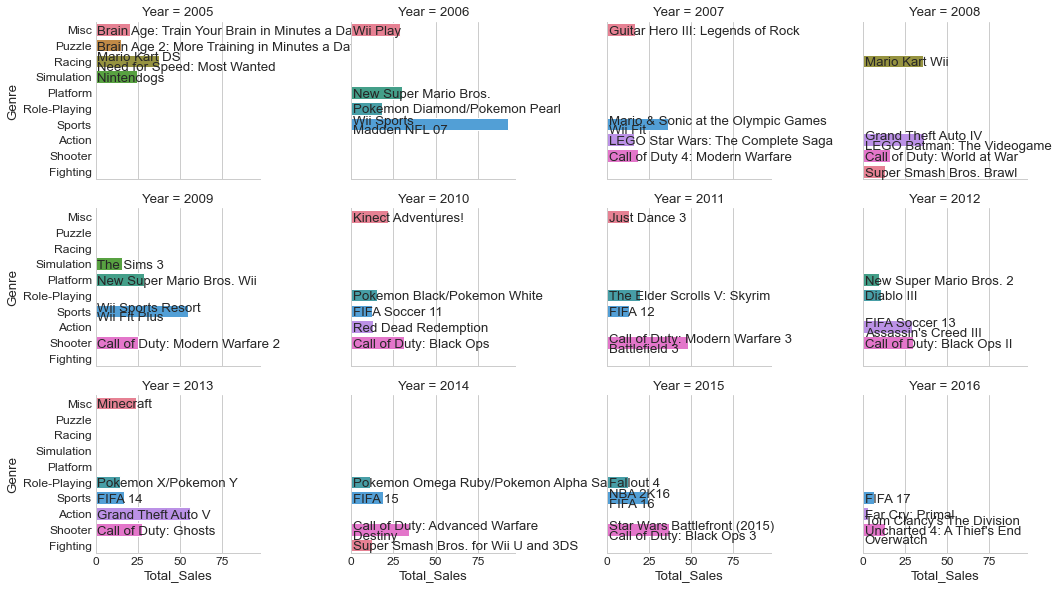

In [29]:
def annotate(data, **kws):
    ax = plt.gca()
    j = 0 
    
    for bar in ax.patches:
        x = bar.get_width()
        y = bar.get_y()
        if not np.isnan(x):
            ax.text(1, y+0.5, data.sort_values('Genre')['Name'].iloc[j],
                    va='center', ha='left', linespacing=0.7)
            j += 1
    ax.set_title(data.iloc[0, 0], fontsize=20)

sns.set(font_scale=1.1)
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(top_5_of_year_sum, col="Year", col_wrap=4,
                  gridspec_kws={"wspace":0.0}, size=2.8, aspect=1.3)
g.map(sns.barplot, "Total_Sales", y=top_5_of_year_sum["Genre"],
      ci=None, palette=sns.color_palette('husl', 9))
g.map_dataframe(annotate)
plt.show()
sns.set(font_scale=1)

여러 플랫폼에서 출시해 출시연도가 다른 게임은 가장 이른 년도로 수정했다.

년도별로 많이 팔린 게임을 보면 판매량이 많은 장르와 항상 일치하진 않는다.<br>
판매량을 기준으로 하면
- 2010년 이전에는 다양한 장르가 나타났다.
- 하지만 그 이후부터는 대부분 롤플레잉, 스포츠, 액션, 슈팅이 순위권에 든다.

2010년 부터 보면
- 롤플레잉은 포켓몬이 항상 높다. 스카이림, 디아블로, 폴아웃4 가 출시됐을 때도 순위권에 있는데, 스카이림과 폴아웃4는 오픈월드 형식의 액션 어드벤처 스타일이다.
- 스포츠는 피파가 점령했다. 
- 액션은 레드 데드 리뎀션, 어쌔신 크리드 3, GTA 5, 파크라이가 있는데 롤플레잉에서 높은 판매량을 올린 스카이림과 폴아웃4와 같은 오픈월드 형식의 액션 어드벤처 스타일이다.
- 슈팅은 콜 오브 듀티 시리즈가 항상 있고, 배틀필드, 데스티니, 더 디비전, 오버워치가 있다.

### 전체 기간 중 판매량

In [30]:
top_sales = (data.groupby(['Name', 'Genre'])[['Year', 'Total_Sales']]
             .agg({'Year': lambda x: sorted(x.values)[0],
                 'Total_Sales': 'sum'}).reset_index()
             .sort_values('Total_Sales', ascending=False)).reset_index(drop=True)

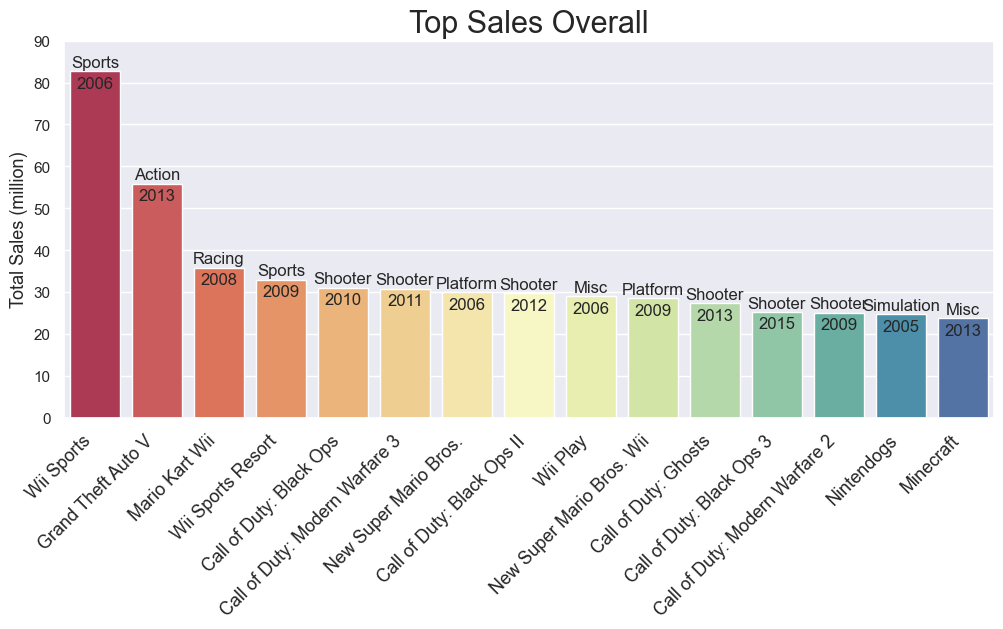

In [31]:
plt.figure(figsize=(12, 5), dpi=100)
sns.barplot(data=top_sales.head(15), x='Name', y='Total_Sales', palette=sns.color_palette('Spectral', 15))
for i in range(15):
    plt.text(x=i, y=top_sales['Total_Sales'][i]+1, s=top_sales['Genre'][i], horizontalalignment='center')
    plt.text(x=i, y=top_sales['Total_Sales'][i]-4, s=top_sales['Year'][i], horizontalalignment='center')
plt.ylim([0, 90])
plt.xticks(rotation=45, fontsize=13, ha='right')
plt.xlabel('')
plt.ylabel("Total Sales (million)", fontsize=13)
plt.title("Top Sales Overall", fontsize=22)
plt.show()

2005년부터 2016년까지 단순 판매량이 많은 순서로 보면 Wii Sports(2006)가 8천만장으로 가장 많이 팔렸다. 다음으로 2013년 출시한 GTA5가 5천만 장 이상의 판매량으로 2위에 올랐다. 이후로는 마리오 카트와 슈퍼마리오 시리즈, 다른 Wii Sports 시리즈인 Will Sports Resort, 콜오브 듀티 등이 순위권에 올랐다.

### 장르별 전체 판매량

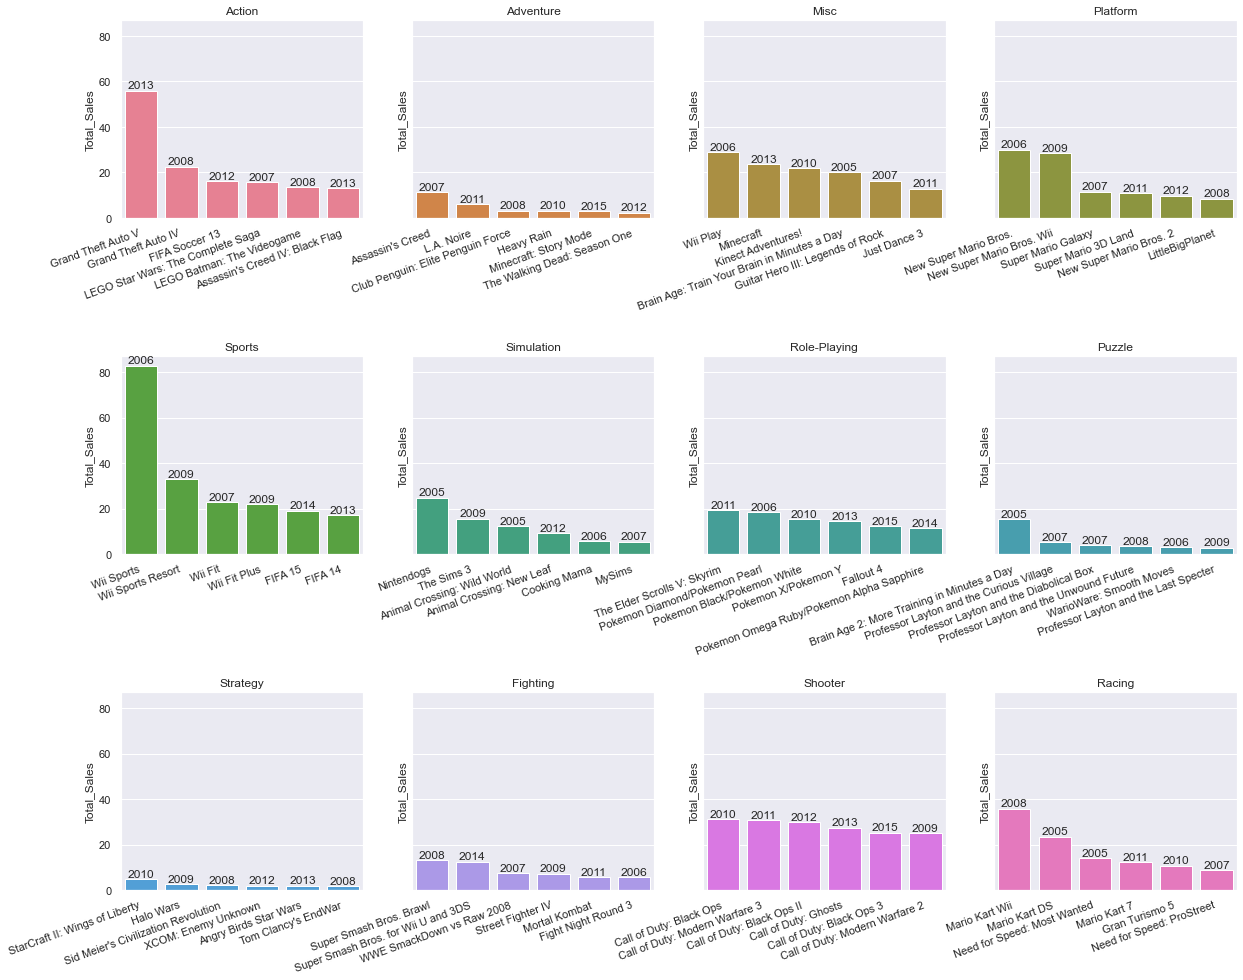

In [32]:
genre = data['Genre'].unique()
colors = sns.color_palette('husl', 12)
fig, axes = plt.subplots(3, 4, figsize=(20, 16), sharey=True)
for i, col in enumerate(genre):
    temp = top_sales.query("Genre==@col")
    sns.barplot(data=temp.head(6), x='Name', y='Total_Sales', ax=axes[i//4, i%4], color=colors[i])
    axes[i//4, i%4].set_xticks(range(6), list(temp.head(6)['Name'].values), rotation=20, ha='right')
    axes[i//4, i%4].set_xlabel('')
    axes[i//4, i%4].set_title(col)
    for j in range(6):
        axes[i//4, i%4].text(x=j, y=temp['Total_Sales'].iloc[j]+1, s=temp['Year'].iloc[j], ha='center')
    
plt.subplots_adjust(hspace=0.7)
plt.show()

장르별로 가장 많이 판매된 게임들을 보면 액션, 스포츠 장르는 특정 게임이 유독 많은 판매량을 올렸다.
슈팅과 롤플레잉 장르는 해마다 성공한 게임들이 비슷한 수준의 판매량을 올렸다. 미분류된 게임(Misc)들은 장르들을 분류가 잘못된 경우도 있는 것으로 보인다.
플랫포머 게임은 슈퍼마리오 시리즈가 상위 5번 째까지 차지했다. 
스포츠는 Wii sports 시리즈, Wii fit과 Wii fit plus가 높은 판매량을 올렸지만 그 이후에는 피파에 밀려 순위권에 들지 못했다.
시뮬레이션은 동물의 숲을 제외하면 모두 2000년대 게임으로 최에는 시뮬레이션 게임이 힘을 못내는 것으로 예측할 수 있다.
롤플레잉은 스카이림과 폴아웃4 이외에는 모두 포켓몬이다.
퍼즐은 모두 닌텐도 게임이다. 두뇌 트레이닝과 와리오웨어를 빼면 레이튼 교수 시리즈다.
전략 게임은 모두 판매량이 낮다.
격투 게임은 마리오 시리즈가 가장 많이 팔렸다.
슈팅은 모두 콜 오브 듀티 시리즈다.
레이싱 게임도 마리오 시리즈가 가장 많이 팔렸고, 그 다음으로 니드 포 스피드 시리즈가 많이 팔렸다.

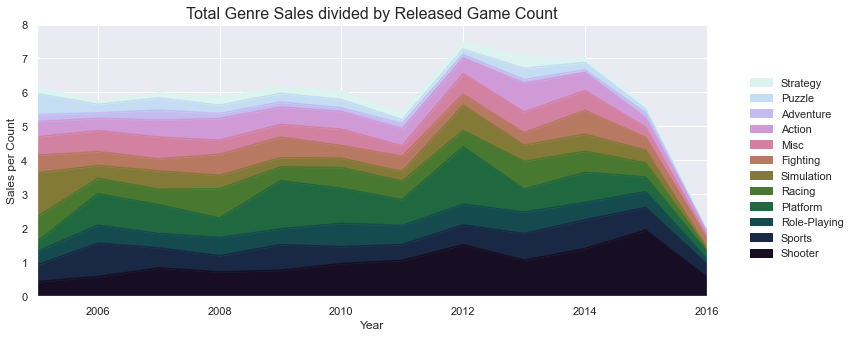

In [33]:
temp = year_genre['sum'].div(year_genre['count'])

fig, ax = plt.subplots(figsize=(12, 5))
temp.T.sort_values(2015, ascending=False).T.plot.area(
    ax=ax, color=sns.color_palette("cubehelix", n_colors=len(temp.columns)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 0.84))
ax.set_xlim(2005, 2016)
ax.set_ylim(0, 8)
plt.title("Total Genre Sales divided by Released Game Count", fontsize=16)
plt.ylabel("Sales per Count", fontsize=12)
plt.show()

### 지역별 장르 선호도 변화

In [34]:
year_region_genre = data.groupby(['Genre', 'Year'])[sales].sum().unstack('Genre')

In [35]:
sum_ = {col: year_region_genre[col].sum(axis=1) for col in sales}

In [36]:
year_region_genre_norm = {}
for col in sales:
    year_region_genre_norm[col] = year_region_genre[col].apply(lambda x: x/sum_[col])

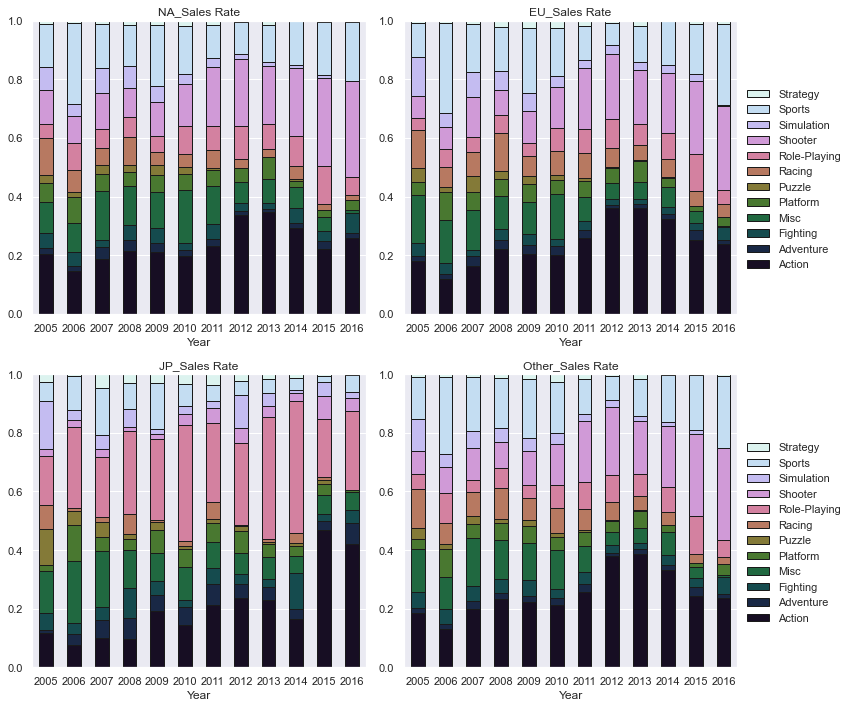

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, col in enumerate(sales):
    year_region_genre_norm[col].plot(kind='bar', stacked=True,
        ax=axes[i//2, i%2],
                                            color=sns.color_palette('cubehelix', 12),
                                             edgecolor='k',
                                     legend='')
    handles, labels = axes[i//2, i%2].get_legend_handles_labels()
    if i%2==1:
        axes[i//2, i%2].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 0.8))
    axes[i//2, i%2].set_xticks(range(12), range(2005, 2017), rotation=0)
    # axes[i//2, i%2].set_xlim(2005, 2016)
    axes[i//2, i%2].set_ylim(0, 1)
    axes[i//2, i%2].set_title(f"{col} Rate")

plt.tight_layout()
plt.show()

지역별 판매량의 비율 변화를 보면 일본을 제외한 지역에서 슈팅의 판매 비율이 점점 증가하고 있다.
액션의 비율은 변동이 있긴 하지만 항상 높다.
일본의 경우 2015년에 액션의 비율이 갑자기 증가했고 이전에는 롤플레잉의 비율이 가장 높았다.
2015년에는 다른 해보다 액션게임의 출시량이 많았다. 2012년에도 액션 게임이 많이 출시되었지만 시뮬레이션 장르의 동물의 숲과 롤플레잉 장르인 포켓몬, 플랫포머 장르인 슈퍼마리오가 출시되어 액션 게임의 판매량이 저조했다.
일본에서 인기있던 롤플레잉 게임은 대부분 포켓몬 시리즈나 몬헌 시리즈다. 포켓몬은 전체 지역에서 판매량이 많지만 몬헌은 일본 내에서 거의 모든 판매량이 집중되어있다. 이로 인해 다른 지역보다 일본에 롤플레잉의 비중이 높게 나타났다.

## 출고량과 메타크티릭 점수 사이 관계

In [38]:
# 적은 메타크리틱 점수 보충
# https://www.kaggle.com/datasets/deepcontractor/top-video-games-19952021-metacritic
# scraped from https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0
metacritic = pd.read_csv('all_games.csv')

In [39]:
metacritic_scores = metacritic.groupby('name')['meta_score'].mean()

data_with_meta = data.merge(metacritic_scores, how='left', left_on='Name', right_on='name')
data_with_meta['Critic_Score'] = data_with_meta['Critic_Score'].fillna(data_with_meta['meta_score'])
data_with_meta = data_with_meta.drop('meta_score', axis=1)

data_with_meta['MetaCritic'] = pd.cut(
    data_with_meta['Critic_Score'], [0, 19, 49, 74, 89, 100],
    labels=['Overwhelming\nDislike', 'Generally\nUnfavorable',
            'Mixed\nor Average', 'Generally\nFavorable', 'Universal\nAcclaim'])

In [40]:
corr = data_with_meta.corrwith(data_with_meta['Critic_Score'])
corr.name = 'Critic_Score'
corr = corr.to_frame()
corr['User_Score'] = data_with_meta.corrwith(data_with_meta['User_Score'])

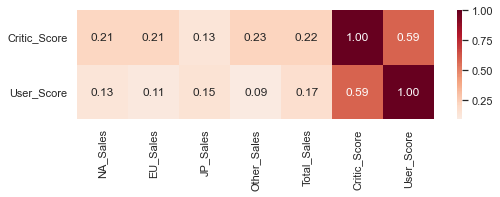

In [41]:
plt.figure(figsize=(8, 2))
sns.heatmap(corr.T.iloc[:, 1:], annot=True, fmt='.2f', center=0, cmap='RdBu_r')
plt.show()

점수들과 판매량엔 큰 상관 계수가 없지만 판매량이 높은 북미와 유럽 지역과 비교적 높은 값을 가진다.

- 높은 판매량 -> 높은 점수? X
- 높은 점수 -> 높은 판매량? V

약 73%의 데이터를 버리고 측정하는거라 매우 부정확함

In [42]:
data['Critic_Score'].isna().sum() / data.shape[0]

0.7280536912751678

In [43]:
top_sales_score = (data_with_meta
                   .groupby(['Name'])[['Year', 'Total_Sales', 'Critic_Score', 'Genre', 'MetaCritic']]
                   .agg({'Year': lambda x: x.values[0],
                         'Total_Sales': 'sum',
                         'Critic_Score': 'mean',
                         'MetaCritic': lambda x: x.values[0],
                         'Genre': lambda x: x.values[0]})
                   .dropna().reset_index()
                   .sort_values("Total_Sales", ascending=False))

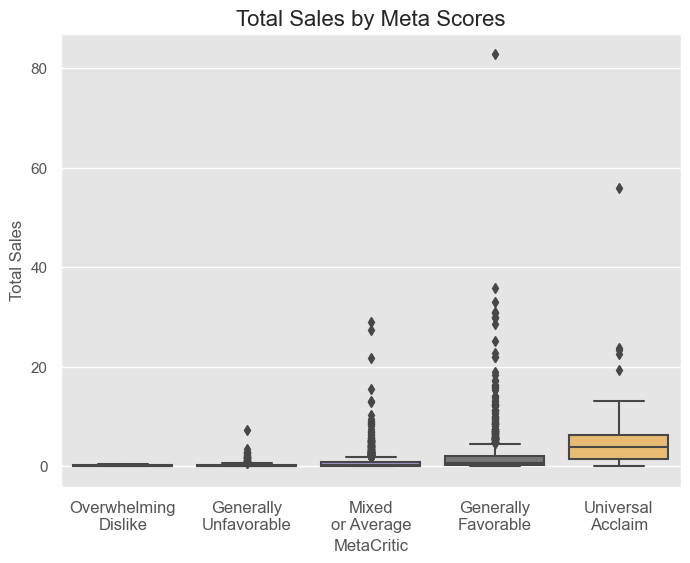

In [44]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6), dpi=100)
sns.boxplot(data=top_sales_score, x='MetaCritic', y='Total_Sales',
            order=['Overwhelming\nDislike', 'Generally\nUnfavorable',
                   'Mixed\nor Average', 'Generally\nFavorable', 'Universal\nAcclaim'])
plt.title("Total Sales by Meta Scores", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.show()

In [45]:
name_score = {k:v for k, v in (top_sales_score[['Name', 'Critic_Score']].values)}

In [46]:
# from https://www.metacritic.com/
missing_score = {'Call of Duty: Black Ops 3': 73,
                 'Nintendogs': 83}

In [47]:
top_sales['Critic_Score'] = top_sales['Name'].map(name_score)
top_sales['Critic_Score'] = top_sales['Critic_Score'].fillna(top_sales['Name'].map(missing_score))

In [48]:
genre_color = {k: v for k, v in 
               zip(top_sales['Genre'].unique(), list(sns.color_palette("husl", 8).as_hex()))}

In [49]:
top_sales['Color'] = top_sales['Genre'].map(genre_color)

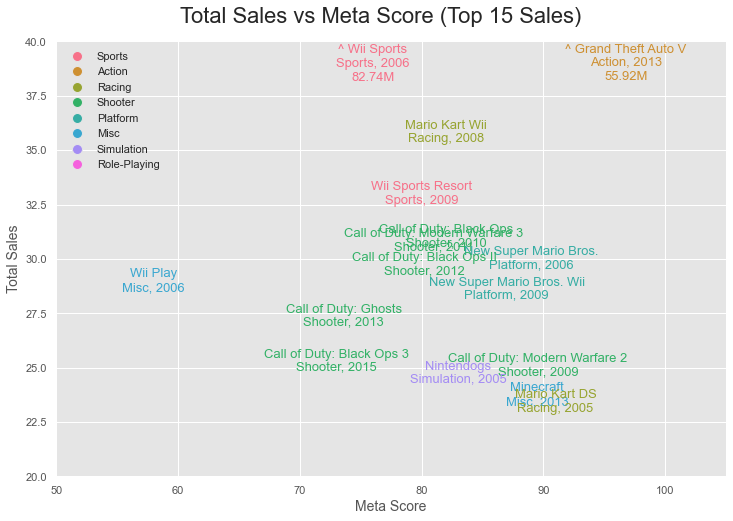

In [50]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=top_sales.head(15), y='Total_Sales', x='Critic_Score', s=0)
for i, (x, y) in enumerate(top_sales[['Critic_Score', 'Total_Sales']].iloc[2:16].values, 2):
    ax.text(x, y, 
            f"{top_sales['Name'].iloc[i]}\n{top_sales['Genre'].iloc[i]}, {top_sales['Year'].iloc[i]}",
            va='center', ha='center',
            fontdict={'size':13, 'color':top_sales['Color'].iloc[i]})
for i, (x, y) in enumerate(top_sales[['Critic_Score', 'Total_Sales']].iloc[:2].values):
    ax.text(x, 39,
            f"^ {top_sales['Name'].iloc[i]}\n{top_sales['Genre'].iloc[i]}, {top_sales['Year'].iloc[i]}\n{round(top_sales['Total_Sales'].iloc[i], 2)}M",
            va='center', ha='center',
            fontdict={'size':13, 'color':top_sales['Color'].iloc[i]})
    
legend_elements = []
for genre, color in genre_color.items():
    legend_elements.append(Line2D([0], [0], marker='o', color='#e5e5e5', label=genre,
                                  markerfacecolor=color, markersize=10))

plt.suptitle("Total Sales vs Meta Score (Top 15 Sales)", fontsize=22, y=0.94)
plt.xlabel("Meta Score", fontsize=14)
plt.ylabel("Total Sales", fontsize=14)
ax.legend(handles=legend_elements, loc='upper left')
plt.xlim(50, 105)
plt.ylim(20, 40)
plt.show()

높은 메타 크리틱 점수(90점 이상)를 받으면 대체로 다른 점수를 받았을 때보다 높은 판매량을 나타지만 가장 많이 팔린 한 게임 다음에는 다수의 대체로 긍정적(74\~89점)인 게임들이 높은 판매량을 기록했다.
복합적(50\~74점)인 경우에도 천만 장 이상 판매된 기록이 있다. 피파13이랑 심즈3이다. 
대체로 부정적이거나 그 아래의 점수에서는 확실히 다른 점수대에 비해 판매량이 낮다.

# Conclusion

차기 작품으로 출시할 게임의 장르는
- 오픈월드형
- 액션 어드벤쳐
- 슈팅

를 포함하는 것이 좋아보인다.